In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="1b5aH9qlySyUZJX3r5VI")
project = rf.workspace("microsoft").project("coco-dataset-vdnr1")
version = project.version(26)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COCO-Dataset-26 in yolov11:: 100%|██████████| 432/432 [00:00<00:00, 7332.25it/s]


In [ ]:
import os
import glob
import shutil
import yaml
import random
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURATION ---
SOURCE_DIR = dataset.location   # The path from your Roboflow download
DEST_DIR = "balanced_dataset"   # New folder name
TARGET_TOTAL = 5000             # Total images desired
SPLIT = "train"                 # We usually only reduce the training set

# 1. Setup Directories
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

for sub in ['images', 'labels']:
    os.makedirs(os.path.join(DEST_DIR, SPLIT, sub), exist_ok=True)

# Copy data.yaml
shutil.copy(os.path.join(SOURCE_DIR, "data.yaml"), os.path.join(DEST_DIR, "data.yaml"))

# Load Class Info
with open(os.path.join(SOURCE_DIR, "data.yaml"), 'r') as f:
    data_info = yaml.safe_load(f)
    num_classes = data_info['nc']
    class_names = data_info['names']

# Calculate Target per Class (e.g., 5000 / 80 = 62 images per class)
target_per_class = TARGET_TOTAL // num_classes
print(f"Aiming for ~{target_per_class} images per class (Total: {TARGET_TOTAL})")

# 2. Scan All Labels
print("Scanning dataset labels...")
label_files = glob.glob(os.path.join(SOURCE_DIR, SPLIT, "labels", "*.txt"))

# Map: class_id -> list of file paths
class_to_files = defaultdict(list)
# Map: file_path -> list of classes in that file
file_to_classes = {}

for l_path in tqdm(label_files):
    with open(l_path, 'r') as f:
        # Get unique classes in this image
        classes_in_img = set()
        for line in f:
            classes_in_img.add(int(line.split()[0]))

        file_to_classes[l_path] = list(classes_in_img)

        for c in classes_in_img:
            class_to_files[c].append(l_path)

# 3. Intelligent Selection (Rare Classes First)
selected_files = set()
current_class_counts = defaultdict(int)

# Sort classes by rarity (fewer images = rarer)
sorted_classes = sorted(range(num_classes), key=lambda k: len(class_to_files[k]))

print("Selecting balanced images...")

# Pass 1: Try to fill quota for each class (starting with rarest)
for cls_id in sorted_classes:
    available_files = class_to_files[cls_id]
    random.shuffle(available_files) # Shuffle for randomness

    for l_path in available_files:
        # If we already have enough for this class, skip
        if current_class_counts[cls_id] >= target_per_class:
            break

        # If file already selected, just verify counts (skip adding)
        if l_path in selected_files:
            continue

        # Select this file
        selected_files.add(l_path)

        # Update counts for ALL classes in this image
        for c in file_to_classes[l_path]:
            current_class_counts[c] += 1

# Pass 2: If we are under 5000, fill with random remaining images
if len(selected_files) < TARGET_TOTAL:
    print(f"Quota filled. Current count: {len(selected_files)}. Filling to {TARGET_TOTAL}...")
    remaining_files = [f for f in label_files if f not in selected_files]
    random.shuffle(remaining_files)

    needed = TARGET_TOTAL - len(selected_files)
    selected_files.update(remaining_files[:needed])

# 4. Copy Files
print(f"Copying {len(selected_files)} images to '{DEST_DIR}'...")
for l_path in tqdm(selected_files):
    # Derive paths
    basename = os.path.basename(l_path)
    img_name_jpg = basename.replace(".txt", ".jpg")
    img_name_png = basename.replace(".txt", ".png") # Check png too

    # Source Paths
    src_lbl = l_path
    src_img_jpg = os.path.join(SOURCE_DIR, SPLIT, "images", img_name_jpg)
    src_img_png = os.path.join(SOURCE_DIR, SPLIT, "images", img_name_png)

    # Destination Paths
    dest_lbl = os.path.join(DEST_DIR, SPLIT, "labels", basename)
    dest_img = os.path.join(DEST_DIR, SPLIT, "images", img_name_jpg)

    # Copy Label
    shutil.copy(src_lbl, dest_lbl)

    # Copy Image (Check extension)
    if os.path.exists(src_img_jpg):
        shutil.copy(src_img_jpg, dest_img)
    elif os.path.exists(src_img_png):
         shutil.copy(src_img_png, dest_img.replace(".jpg", ".png"))

print("\n✅ Dataset reduced successfully!")
print(f"New dataset location: {os.path.abspath(DEST_DIR)}")

Aiming for ~64 images per class (Total: 5000)
Scanning dataset labels...


100%|██████████| 5/5 [00:00<00:00, 2985.69it/s]


Selecting balanced images...
Quota filled. Current count: 5. Filling to 5000...
Copying 5 images to 'balanced_dataset'...


100%|██████████| 5/5 [00:00<00:00, 1801.06it/s]


✅ Dataset reduced successfully!
New dataset location: /content/balanced_dataset


In [ ]:
import os
import glob
import shutil
import yaml
import random
import math
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURATION ---
SOURCE_DIR = dataset.location   # Path to original large dataset
DEST_DIR = "balanced_dataset"   # New folder name
TARGET_TOTAL = 5000             # Total size of the new dataset
SOURCE_SPLIT = "train"          # We pull images from the original 'train' folder

# Split Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# 1. Setup Directories
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

# Create train, val, test subfolders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DEST_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DEST_DIR, split, 'labels'), exist_ok=True)

# Copy and Update data.yaml
yaml_src = os.path.join(SOURCE_DIR, "data.yaml")
yaml_dst = os.path.join(DEST_DIR, "data.yaml")

# We read the original yaml to get class names
with open(yaml_src, 'r') as f:
    data_info = yaml.safe_load(f)
    num_classes = data_info['nc']
    class_names = data_info['names']

# Save new yaml pointing to local folders
# YOLO automatically finds train/val/test if they are in the same folder as data.yaml
new_yaml_data = {
    'path': os.path.abspath(DEST_DIR), # Absolute path is safer
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': num_classes,
    'names': class_names
}

with open(yaml_dst, 'w') as f:
    yaml.dump(new_yaml_data, f)


# --- SELECTION LOGIC (Same as before) ---

# Calculate Target per Class
target_per_class = TARGET_TOTAL // num_classes
print(f"Aiming for ~{target_per_class} images per class (Total: {TARGET_TOTAL})")

print("Scanning source labels...")
label_files = glob.glob(os.path.join(SOURCE_DIR, SOURCE_SPLIT, "labels", "*.txt"))

# Map: class_id -> list of file paths
class_to_files = defaultdict(list)
file_to_classes = {}

for l_path in tqdm(label_files):
    with open(l_path, 'r') as f:
        classes_in_img = set()
        for line in f:
            try:
                classes_in_img.add(int(line.split()[0]))
            except:
                pass # skip bad lines

        file_to_classes[l_path] = list(classes_in_img)
        for c in classes_in_img:
            class_to_files[c].append(l_path)

selected_files = set()
current_class_counts = defaultdict(int)
sorted_classes = sorted(range(num_classes), key=lambda k: len(class_to_files[k]))

print("Selecting balanced images...")

# Pass 1: Rare classes first
for cls_id in sorted_classes:
    available_files = class_to_files[cls_id]
    random.shuffle(available_files)

    for l_path in available_files:
        if current_class_counts[cls_id] >= target_per_class:
            break
        if l_path in selected_files:
            continue

        selected_files.add(l_path)
        for c in file_to_classes.get(l_path, []):
            current_class_counts[c] += 1

# Pass 2: Fill remainder
if len(selected_files) < TARGET_TOTAL:
    print(f"Quota filled. Current count: {len(selected_files)}. Filling to {TARGET_TOTAL}...")
    remaining_files = [f for f in label_files if f not in selected_files]
    random.shuffle(remaining_files)
    selected_files.update(remaining_files[:TARGET_TOTAL - len(selected_files)])

# --- SPLIT LOGIC (NEW) ---

print(f"Splitting {len(selected_files)} images into Train/Val/Test...")

# Convert set to list and shuffle
all_files = list(selected_files)
random.shuffle(all_files)

# Calculate indices
n_total = len(all_files)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)
# n_test is the rest

train_files = all_files[:n_train]
val_files = all_files[n_train:n_train + n_val]
test_files = all_files[n_train + n_val:]

print(f"Counts -> Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

# Helper function to copy
def copy_set(file_list, split_name):
    print(f"Copying to {split_name}...")
    for l_path in tqdm(file_list):
        basename = os.path.basename(l_path)
        img_name_jpg = basename.replace(".txt", ".jpg")
        img_name_png = basename.replace(".txt", ".png")

        # Source Image Path
        src_img_jpg = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", img_name_jpg)
        src_img_png = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", img_name_png)

        # Destination Paths
        dest_lbl = os.path.join(DEST_DIR, split_name, "labels", basename)
        dest_img = os.path.join(DEST_DIR, split_name, "images", img_name_jpg) # Default to jpg name

        # Copy Label
        shutil.copy(l_path, dest_lbl)

        # Copy Image
        if os.path.exists(src_img_jpg):
            shutil.copy(src_img_jpg, dest_img)
        elif os.path.exists(src_img_png):
            # If png, make sure dest has .png extension
            shutil.copy(src_img_png, dest_img.replace(".jpg", ".png"))

# Execute Copies
copy_set(train_files, 'train')
copy_set(val_files, 'val')
copy_set(test_files, 'test')

print(f"\n✅ Balanced Dataset Generated at: {os.path.abspath(DEST_DIR)}")
print("You can now train using 'balanced_dataset/data.yaml'")

Aiming for ~64 images per class (Total: 5000)
Scanning source labels...


100%|██████████| 5/5 [00:00<00:00, 5854.70it/s]


Selecting balanced images...
Quota filled. Current count: 5. Filling to 5000...
Splitting 5 images into Train/Val/Test...
Counts -> Train: 4, Val: 0, Test: 1
Copying to train...


100%|██████████| 4/4 [00:00<00:00, 1455.47it/s]


Copying to val...


0it [00:00, ?it/s]


Copying to test...


100%|██████████| 1/1 [00:00<00:00, 1846.90it/s]


✅ Balanced Dataset Generated at: /content/balanced_dataset
You can now train using 'balanced_dataset/data.yaml'


⚠️ Warning: Malformed label line in balanced_dataset/train/labels/000000000321_jpg.rf.ca3e75ab466ecaedb377d11f742d5843.txt for image 000000000321_jpg.rf.ca3e75ab466ecaedb377d11f742d5843.jpg: '37 0.7429375 0.8490208333333333 0.785296875 0.8866666666666667 0.854125 0.91725 0.9035312499999999 0.8937291666666667 0.9211718750000001 0.8419583333333334 0.9370624999999999 0.851375 0.9441250000000001 0.8090208333333334 0.95646875 0.7666666666666666 0.951171875 0.7501875 0.868234375 0.6631458333333333 0.81 0.5855 0.7129374999999999 0.45608333333333334 0.672359375 0.4160833333333333 0.651171875 0.4301875 0.63 0.45608333333333334 0.6017656250000001 0.46314583333333337 0.582359375 0.48902083333333335 0.5770625 0.5243125 0.568234375 0.5807916666666666 0.575296875 0.6113749999999999 0.608828125 0.6866666666666666 0.718234375 0.8231458333333334 0.7429375 0.8490208333333333'. Expected 5 values (class_id + 4 coords), got 47. Taking first 4 coordinate values.
⚠️ Warning: Malformed label line in balanced_

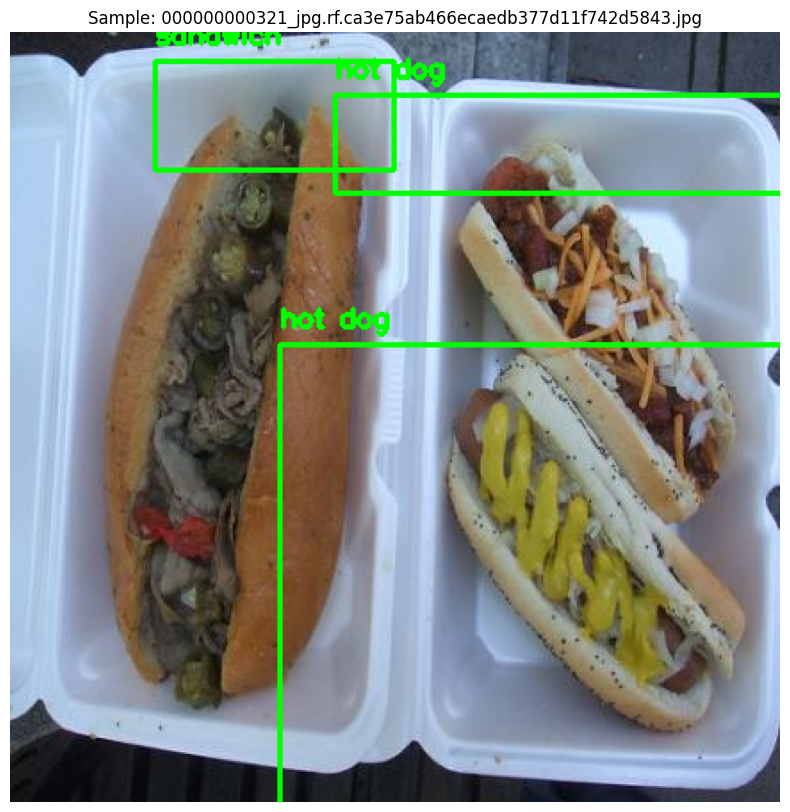

In [ ]:
import cv2
import matplotlib.pyplot as plt
import yaml
import random
import os

def visualize_random_sample(root_dir, split='train'):
    # 1. Get list of images
    img_dir = os.path.join(root_dir, split, "images")
    lbl_dir = os.path.join(root_dir, split, "labels")

    all_images = os.listdir(img_dir)
    if not all_images:
        print("No images found to visualize.")
        return

    # 2. Pick random image
    random_file = random.choice(all_images)
    img_path = os.path.join(img_dir, random_file)

    # Construct label path (same name but .txt)
    file_name_no_ext = os.path.splitext(random_file)[0]
    lbl_path = os.path.join(lbl_dir, file_name_no_ext + ".txt")

    # 3. Load Image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # 4. Try to load class names from data.yaml if it exists
    class_names = None
    yaml_path = os.path.join(root_dir, "data.yaml")
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
            # 'names' key in data.yaml is typically a list for YOLO datasets
            class_names = data_yaml.get('names', []) # Default to empty list if not found

    # 5. Read Labels and Draw Boxes
    if os.path.exists(lbl_path):
        with open(lbl_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue # Skip empty lines

            cls_id = int(parts[0])

            # YOLO format: class x_center y_center width height (normalized)
            # Ensure there are at least 4 coordinate values
            if len(parts) < 5:
                print(f"⚠️ Warning: Malformed label line in {lbl_path} for image {random_file}: '{line.strip()}'. Expected at least 5 values (class_id + 4 coords), got {len(parts)}. Skipping this bounding box.")
                continue
            if len(parts) > 5:
                print(f"⚠️ Warning: Malformed label line in {lbl_path} for image {random_file}: '{line.strip()}'. Expected 5 values (class_id + 4 coords), got {len(parts)}. Taking first 4 coordinate values.")

            # Take only the first 4 coordinate values (elements from index 1 to 4)
            nx, ny, nw, nh = map(float, parts[1:5])

            # Convert normalized coordinates to pixel coordinates
            x1 = int((nx - nw / 2) * w)
            y1 = int((ny - nh / 2) * h)
            x2 = int((nx + nw / 2) * w)
            y2 = int((ny + nh / 2) * h)

            # Draw Rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Label Text
            label_text = f"Class {cls_id}"
            if class_names and cls_id < len(class_names): # Check if class_names is a list and ID is valid
                label_text = class_names[cls_id]

            cv2.putText(image, label_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Sample: {random_file}")
    plt.show()

# Run visualization on the Training set
visualize_random_sample(DEST_DIR, "train")

In [ ]:
import os
import glob
import random
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # For progress bars

# --- UPDATE CONFIGURATION HERE ---
DATASET_DIR = "balanced_dataset"  # CHANGED: Points to your new balanced folder
SPLIT = "train"                 # We are analyzing the reduced training set

# Paths
images_dir = os.path.join(DATASET_DIR, SPLIT, "images")
labels_dir = os.path.join(DATASET_DIR, SPLIT, "labels")
yaml_path = os.path.join(DATASET_DIR, "data.yaml")

# Load Class Names
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
else:
    class_names = {} # Fallback if no yaml found

print(f"Analyzing dataset at: {images_dir}")

Analyzing dataset at: balanced_dataset/train/images


In [ ]:
import os
import glob
import shutil
import yaml
import random
import math
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURATION UPDATED ---
SOURCE_DIR = "COCO-Dataset-2"   # CHANGED: Points directly to your existing folder
DEST_DIR = "balanced_dataset"   # New folder name
TARGET_TOTAL = 5000             # Total size of the new dataset
SOURCE_SPLIT = "train"          # We pull images from the original 'train' folder

# Split Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# 1. Setup Directories
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

# Create train, val, test subfolders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DEST_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DEST_DIR, split, 'labels'), exist_ok=True)

# Copy and Update data.yaml
yaml_src = os.path.join(SOURCE_DIR, "data.yaml")
yaml_dst = os.path.join(DEST_DIR, "data.yaml")

# We read the original yaml to get class names
if os.path.exists(yaml_src):
    with open(yaml_src, 'r') as f:
        data_info = yaml.safe_load(f)
        num_classes = data_info['nc']
        class_names = data_info['names']
else:
    print(f"❌ Error: Could not find data.yaml in {SOURCE_DIR}")
    # You might need to adjust this if your yaml is inside 'train' or elsewhere
    exit()

# Save new yaml pointing to local folders
# YOLO automatically finds train/val/test if they are in the same folder as data.yaml
new_yaml_data = {
    'path': os.path.abspath(DEST_DIR), # Absolute path is safer
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': num_classes,
    'names': class_names
}

with open(yaml_dst, 'w') as f:
    yaml.dump(new_yaml_data, f)


# --- SELECTION LOGIC ---

# Calculate Target per Class
target_per_class = TARGET_TOTAL // num_classes
print(f"Aiming for ~{target_per_class} images per class (Total: {TARGET_TOTAL})")

print("Scanning source labels...")
label_files = glob.glob(os.path.join(SOURCE_DIR, SOURCE_SPLIT, "labels", "*.txt"))

if not label_files:
    print(f"❌ Error: No labels found in {os.path.join(SOURCE_DIR, SOURCE_SPLIT, 'labels')}")
    exit()

# Map: class_id -> list of file paths
class_to_files = defaultdict(list)
file_to_classes = {}

for l_path in tqdm(label_files):
    with open(l_path, 'r') as f:
        classes_in_img = set()
        for line in f:
            try:
                classes_in_img.add(int(line.split()[0]))
            except:
                pass # skip bad lines

        file_to_classes[l_path] = list(classes_in_img)
        for c in classes_in_img:
            class_to_files[c].append(l_path)

selected_files = set()
current_class_counts = defaultdict(int)
sorted_classes = sorted(range(num_classes), key=lambda k: len(class_to_files[k]))

print("Selecting balanced images...")

# Pass 1: Rare classes first
for cls_id in sorted_classes:
    available_files = class_to_files[cls_id]
    random.shuffle(available_files)

    for l_path in available_files:
        if current_class_counts[cls_id] >= target_per_class:
            break
        if l_path in selected_files:
            continue

        selected_files.add(l_path)
        for c in file_to_classes.get(l_path, []):
            current_class_counts[c] += 1

# Pass 2: Fill remainder
if len(selected_files) < TARGET_TOTAL:
    print(f"Quota filled. Current count: {len(selected_files)}. Filling to {TARGET_TOTAL}...")
    remaining_files = [f for f in label_files if f not in selected_files]
    random.shuffle(remaining_files)
    selected_files.update(remaining_files[:TARGET_TOTAL - len(selected_files)])

# --- SPLIT LOGIC ---

print(f"Splitting {len(selected_files)} images into Train/Val/Test...")

# Convert set to list and shuffle
all_files = list(selected_files)
random.shuffle(all_files)

# Calculate indices
n_total = len(all_files)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)
# n_test is the rest

train_files = all_files[:n_train]
val_files = all_files[n_train:n_train + n_val]
test_files = all_files[n_train + n_val:]

print(f"Counts -> Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

# Helper function to copy
def copy_set(file_list, split_name):
    print(f"Copying to {split_name}...")
    for l_path in tqdm(file_list):
        basename = os.path.basename(l_path)
        img_name_jpg = basename.replace(".txt", ".jpg")
        img_name_png = basename.replace(".txt", ".png")

        # Source Image Path
        src_img_jpg = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", img_name_jpg)
        src_img_png = os.path.join(SOURCE_DIR, SOURCE_SPLIT, "images", img_name_png)

        # Destination Paths
        dest_lbl = os.path.join(DEST_DIR, split_name, "labels", basename)
        dest_img = os.path.join(DEST_DIR, split_name, "images", img_name_jpg) # Default to jpg name

        # Copy Label
        shutil.copy(l_path, dest_lbl)

        # Copy Image
        if os.path.exists(src_img_jpg):
            shutil.copy(src_img_jpg, dest_img)
        elif os.path.exists(src_img_png):
            # If png, make sure dest has .png extension
            shutil.copy(src_img_png, dest_img.replace(".jpg", ".png"))

# Execute Copies
copy_set(train_files, 'train')
copy_set(val_files, 'val')
copy_set(test_files, 'test')

print(f"\n✅ Balanced Dataset Generated at: {os.path.abspath(DEST_DIR)}")
print("You can now train using 'balanced_dataset/data.yaml'")

Aiming for ~62 images per class (Total: 5000)
Scanning source labels...


100%|██████████| 85318/85318 [00:06<00:00, 13260.97it/s]


Selecting balanced images...
Quota filled. Current count: 2517. Filling to 5000...
Splitting 5000 images into Train/Val/Test...
Counts -> Train: 4000, Val: 500, Test: 500
Copying to train...


100%|██████████| 4000/4000 [00:09<00:00, 421.41it/s]


Copying to val...


100%|██████████| 500/500 [00:01<00:00, 410.81it/s]


Copying to test...


100%|██████████| 500/500 [00:01<00:00, 412.16it/s]


✅ Balanced Dataset Generated at: /content/balanced_dataset
You can now train using 'balanced_dataset/data.yaml'


Scanning labels in: balanced_dataset/train/labels
Counting classes in 4000 files...


100%|██████████| 4000/4000 [00:00<00:00, 16029.61it/s]


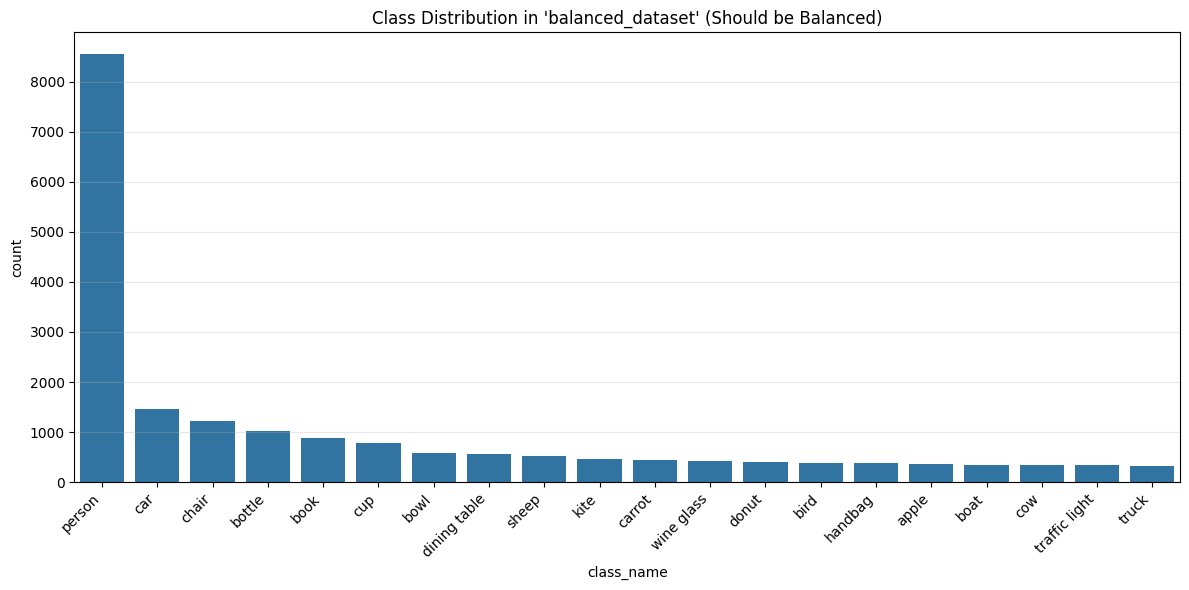

In [ ]:
import os
import glob
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. CONFIGURATION FOR BALANCED DATASET ---
DATASET_DIR = "balanced_dataset"  # Pointing to the new folder
SPLIT = "train"

# Define Paths explicitly
labels_dir = os.path.join(DATASET_DIR, SPLIT, "labels")
yaml_path = os.path.join(DATASET_DIR, "data.yaml")

# Load Class Names from the new data.yaml
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
else:
    class_names = {}
    print("⚠️ Warning: data.yaml not found in balanced_dataset!")

# --- 2. PLOTTING FUNCTION ---
def plot_class_distribution():
    # Verify we are looking at the right folder
    print(f"Scanning labels in: {labels_dir}")

    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))
    if not label_files:
        print("❌ No labels found! Check if the path is correct.")
        return

    class_counts = []

    print(f"Counting classes in {len(label_files)} files...")
    for l_file in tqdm(label_files):
        with open(l_file, 'r') as f:
            for line in f:
                # Handle empty lines or bad formatting
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counts.append(class_id)

    if not class_counts:
        print("No objects found in the label files.")
        return

    # Create DataFrame
    df_counts = pd.DataFrame(class_counts, columns=['class_id'])

    # Map ID to Name
    if class_names:
        if isinstance(class_names, list):
            df_counts['class_name'] = df_counts['class_id'].apply(
                lambda x: class_names[x] if x < len(class_names) else str(x)
            )
        elif isinstance(class_names, dict):
             df_counts['class_name'] = df_counts['class_id'].map(class_names)
    else:
        df_counts['class_name'] = df_counts['class_id'].astype(str)

    # Plot
    plt.figure(figsize=(12, 6))

    # COUNTPLOT: With a balanced dataset, these bars should be roughly similar height!
    sns.countplot(data=df_counts, x='class_name',
                  order=df_counts['class_name'].value_counts().index[:20]) # Top 20

    plt.xticks(rotation=45, ha='right')
    plt.title(f"Class Distribution in '{DATASET_DIR}' (Should be Balanced)")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- 3. EXECUTE ---
plot_class_distribution()

Analyzing dataset at: balanced_dataset/train/images
Analyzing image sizes...


100%|██████████| 500/500 [00:00<00:00, 8509.30it/s]


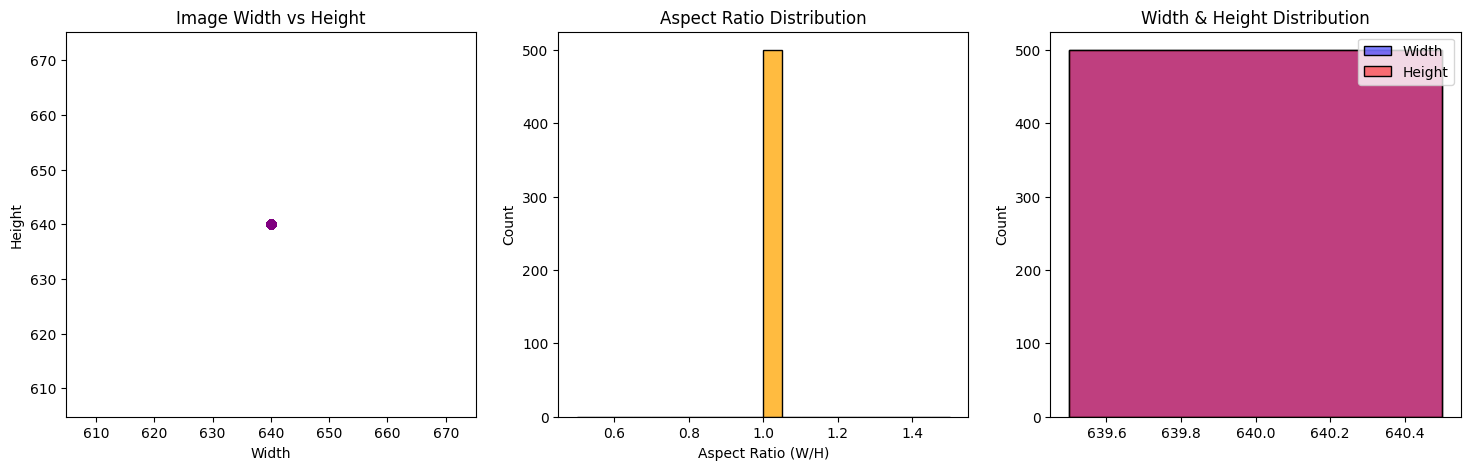

In [ ]:
import os
import glob
import random
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # For progress bars

# --- CONFIGURATION (Copied from DwlyWTz90U0J to make it self-contained) ---
DATASET_DIR = "balanced_dataset"
SPLIT = "train"

# Paths
images_dir = os.path.join(DATASET_DIR, SPLIT, "images")
labels_dir = os.path.join(DATASET_DIR, SPLIT, "labels")
yaml_path = os.path.join(DATASET_DIR, "data.yaml")

# Load Class Names
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
else:
    class_names = {} # Fallback if no yaml found

print(f"Analyzing dataset at: {images_dir}")

def plot_image_sizes():
    img_files = glob.glob(os.path.join(images_dir, "*"))[:500] # Limit to 500 images for speed
    widths = []
    heights = []
    aspect_ratios = []

    print("Analyzing image sizes...")
    for img_file in tqdm(img_files):
        # Open efficiently without loading pixel data
        with Image.open(img_file) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)

    # Plots
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Width vs Height Scatter
    ax[0].scatter(widths, heights, alpha=0.5, color='purple')
    ax[0].set_title("Image Width vs Height")
    ax[0].set_xlabel("Width")
    ax[0].set_ylabel("Height")

    # Aspect Ratio Histogram
    sns.histplot(aspect_ratios, bins=20, ax=ax[1], color='orange')
    ax[1].set_title("Aspect Ratio Distribution")
    ax[1].set_xlabel("Aspect Ratio (W/H)")

    # Size Histogram
    sns.histplot(widths, color='blue', label='Width', ax=ax[2], kde=True)
    sns.histplot(heights, color='red', label='Height', ax=ax[2], kde=True)
    ax[2].set_title("Width & Height Distribution")
    ax[2].legend()

    plt.show()

plot_image_sizes()

Calculating pixel intensities (Sample 50)...


100%|██████████| 50/50 [00:00<00:00, 321.93it/s]


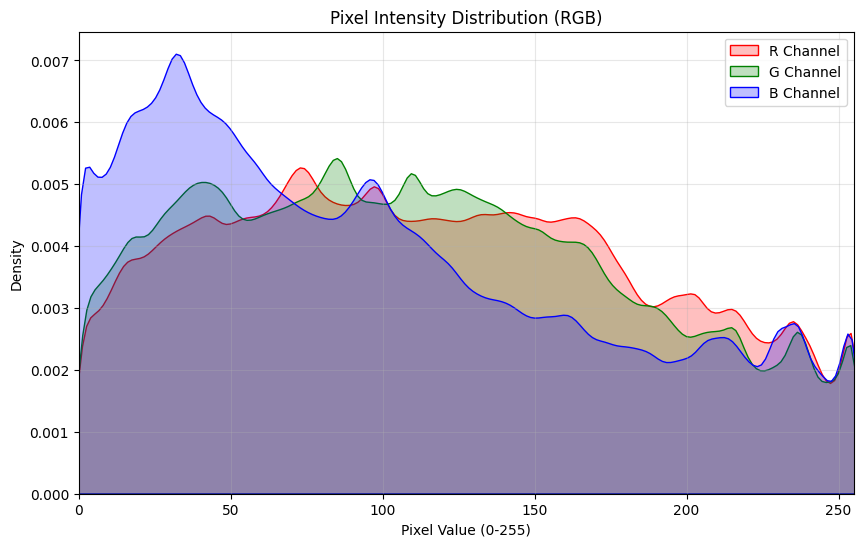

In [ ]:
def plot_pixel_intensity():
    img_files = glob.glob(os.path.join(images_dir, "*"))
    if not img_files: return

    # Sample 50 images to save memory/time
    sample_files = random.sample(img_files, min(len(img_files), 50))

    pixel_values = []

    print("Calculating pixel intensities (Sample 50)...")
    for img_file in tqdm(sample_files):
        img = cv2.imread(img_file)
        if img is not None:
            # Convert to RGB and flatten
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixel_values.append(img.reshape(-1, 3))

    # Concatenate all pixels
    all_pixels = np.vstack(pixel_values)

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        sns.kdeplot(all_pixels[:, i], color=color, fill=True, label=color.upper() + " Channel")

    plt.title("Pixel Intensity Distribution (RGB)")
    plt.xlabel("Pixel Value (0-255)")
    plt.xlim(0, 255)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_pixel_intensity()

In [ ]:
import os
import glob
import cv2
import shutil
from tqdm import tqdm

# CONFIGURATION
DATASET_DIR = "balanced_dataset"
SPLITS = ['train', 'valid', 'test']
QUARANTINE_DIR = "quarantine_data"  # Where bad files go

# Create quarantine folder
if not os.path.exists(QUARANTINE_DIR):
    os.makedirs(QUARANTINE_DIR)

def move_to_quarantine(img_path, lbl_path, reason):
    """Moves bad files out of the dataset."""
    print(f"⚠️ Removing {os.path.basename(img_path)}: {reason}")

    # Create subfolder in quarantine
    dest = os.path.join(QUARANTINE_DIR, reason)
    os.makedirs(dest, exist_ok=True)

    # Move Image
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(dest, os.path.basename(img_path)))

    # Move Label
    if lbl_path and os.path.exists(lbl_path):
        shutil.move(lbl_path, os.path.join(dest, os.path.basename(lbl_path)))

def clean_dataset():
    for split in SPLITS:
        img_dir = os.path.join(DATASET_DIR, split, 'images')
        lbl_dir = os.path.join(DATASET_DIR, split, 'labels')

        if not os.path.exists(img_dir): continue

        img_files = glob.glob(os.path.join(img_dir, "*"))

        print(f"Scanning {split} set ({len(img_files)} files)...")

        for img_path in tqdm(img_files):
            # 1. Define Label Path
            basename = os.path.splitext(os.path.basename(img_path))[0]
            lbl_path = os.path.join(lbl_dir, basename + ".txt")

            # 2. Check for Corrupt Image
            try:
                img = cv2.imread(img_path)
                if img is None:
                    move_to_quarantine(img_path, lbl_path, "corrupt_image")
                    continue
            except Exception:
                move_to_quarantine(img_path, lbl_path, "corrupt_image")
                continue

            # 3. Check Label Validity
            if os.path.exists(lbl_path):
                with open(lbl_path, 'r') as f:
                    lines = f.readlines()

                # If file exists but is empty, it's a background image (Valid in YOLO)
                if not lines:
                    continue

                valid_label = True
                for line in lines:
                    parts = list(map(float, line.strip().split()))

                    # Check 1: Format length (Class + 4 coords minimum)
                    if len(parts) < 5:
                        valid_label = False
                        break

                    # Check 2: Normalization (Coordinates must be between 0 and 1)
                    # parts[1] = x_center, parts[2] = y_center, parts[3] = width, parts[4] = height
                    if any(c > 1.0 or c < 0.0 for c in parts[1:5]):
                        valid_label = False
                        print(f"Non-normalized coords found in {basename}")
                        break

                if not valid_label:
                    move_to_quarantine(img_path, lbl_path, "invalid_coordinates")

clean_dataset()
print("\n✅ Cleaning complete. Check 'quarantine_data' folder for removed files.")

Scanning train set (4000 files)...


100%|██████████| 4000/4000 [00:13<00:00, 287.95it/s]


Scanning test set (500 files)...


100%|██████████| 500/500 [00:01<00:00, 367.12it/s]


✅ Cleaning complete. Check 'quarantine_data' folder for removed files.


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# 1. Load the Segmentation Model (Small Version)
# 's-seg' is faster than 'm' (Medium) but slower than 'n' (Nano).
model = YOLO('yolo11s-seg.pt')

# 2. Define Speed-Optimized Arguments
train_args = {
    "data": "balanced_dataset/data.yaml",

    # --- TIME SAVERS (Goal: < 40 mins) ---
    "epochs": 10,           # Keep low for a quick test
    "imgsz": 416,           # Small image size drastically speeds up segmentation
    "batch": 4,             # Kept safe for memory
    "workers": 8,           # High workers to process polygon masks faster
    "cache": True,          # Essential for speed
    "patience": 5,          # Stop early if not learning

    # --- IMBALANCE HANDLING (Lightweight) ---
    "mixup": 0.1,
    "mosaic": 1.0,

    # --- SPECIFIC TO SEGMENTATION ---
    "overlap_mask": True,   # Handle overlapping objects (common in COCO)
    "mask_ratio": 4,        # Downsample masks to speed up training
}

# 3. Train
print("Starting Segmentation Training (YOLO11s-seg)...")
model.train(**train_args)

Starting Segmentation Training (YOLO11s-seg)...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=balanced_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a15c56378f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017

In [ ]:
from ultralytics import YOLO
import os

# 1. Locate your trained model weights
# NOTE: If you ran training multiple times, this might be inside "train2", "train3", etc.
# Check your file explorer on the left under "runs/segment/"
weights_path = 'runs/segment/train/weights/best.pt'

if not os.path.exists(weights_path):
    print(f"⚠️ Could not find weights at {weights_path}. Please check the 'runs' folder.")
else:
    print(f"✅ Loading weights from: {weights_path}")
    model = YOLO(weights_path)

✅ Loading weights from: runs/segment/train/weights/best.pt


In [ ]:
# 2. Run Evaluation
print("Evaluating on Test Set...")
metrics = model.val(
    data="balanced_dataset/data.yaml",
    split="test",       # Use the unseen 'test' set
    imgsz=416,          # MUST match the size you used for training
    batch=4,
    conf=0.25,          # Confidence threshold (only count predictions > 25% sure)
    iou=0.6             # Intersection over Union threshold
)

# 3. Print Key Results
print("\n--- SEGMENTATION RESULTS ---")
print(f"Mask mAP50-95: {metrics.seg.map:.4f} (Main Metric)")
print(f"Mask mAP50:    {metrics.seg.map50:.4f}")

print("\n--- BOX RESULTS ---")
print(f"Box mAP50-95:  {metrics.box.map:.4f}")
print(f"Box mAP50:     {metrics.box.map50:.4f}")

Evaluating on Test Set...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,097,776 parameters, 0 gradients, 33.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 36.6±12.5 MB/s, size: 72.2 KB)
val: Scanning /content/balanced_dataset/test/labels... 500 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 223.9it/s 2.2s
val: New cache created: /content/balanced_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 125/125 9.3it/s 13.5s
                   all        500       4057      0.589      0.483      0.558      0.421      0.572      0.469       0.54      0.355
              airplane         12         28        0.8      0.571      0.737       0.56        0.8      0.571      0.737      0.486
                 apple         11         26      0.556      0.231      0.403  


image 1/1 /content/balanced_dataset/test/images/000000097696_jpg.rf.88100d598ef824482071c1b9902806a4.jpg: 416x416 1 keyboard, 1 laptop, 1 mouse, 1 tv, 14.1ms
Speed: 28.7ms preprocess, 14.1ms inference, 45.4ms postprocess per image at shape (1, 3, 416, 416)


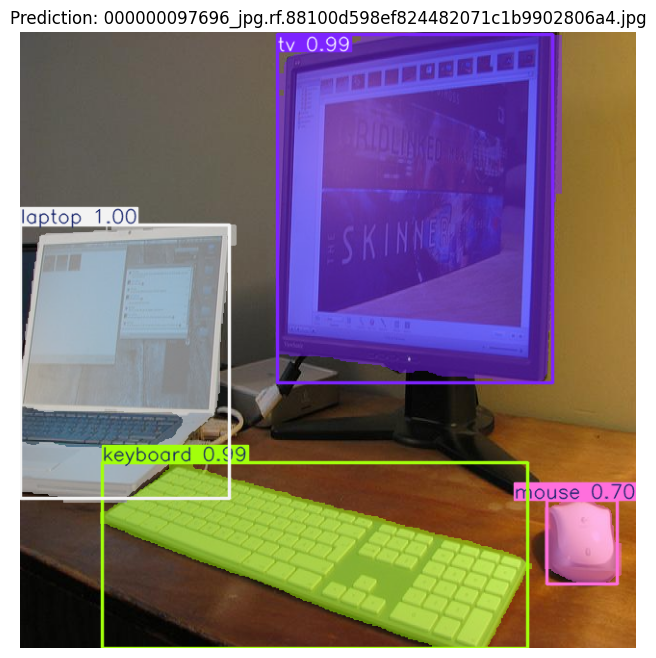


image 1/1 /content/balanced_dataset/test/images/000000289019_jpg.rf.b56e18f7559cc65f3dfe118149feec2a.jpg: 416x416 1 horse, 6 persons, 18.3ms
Speed: 2.9ms preprocess, 18.3ms inference, 21.4ms postprocess per image at shape (1, 3, 416, 416)


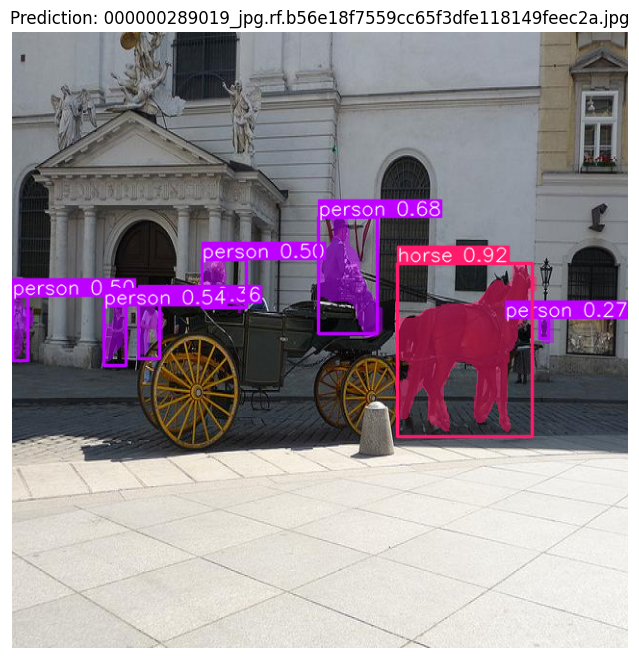


image 1/1 /content/balanced_dataset/test/images/000000396260_jpg.rf.3fd51729b093f63cc517ae115fb47bfc.jpg: 416x416 2 suitcases, 17.2ms
Speed: 2.8ms preprocess, 17.2ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


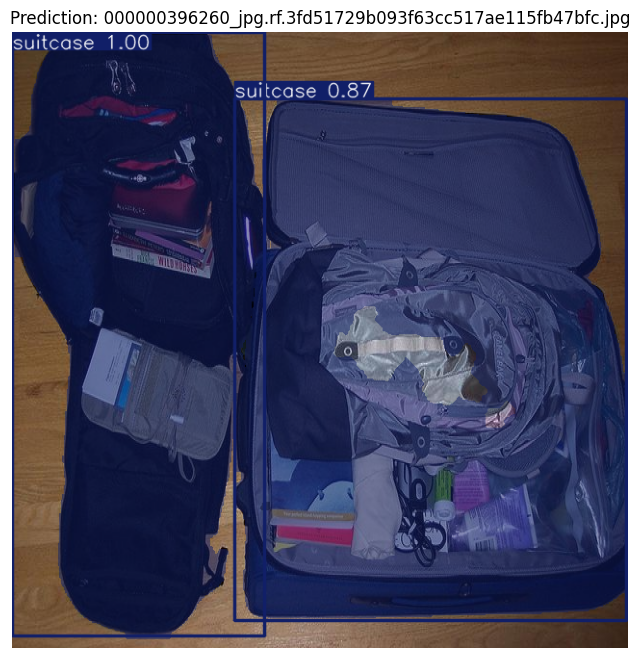

In [ ]:
import matplotlib.pyplot as plt
import glob
import random
import cv2

def predict_and_plot():
    # Get images from the test set
    test_images = glob.glob("balanced_dataset/test/images/*")

    if not test_images:
        print("No images found in test folder.")
        return

    # Pick 3 random images
    samples = random.sample(test_images, 3)

    for img_path in samples:
        # Run inference
        results = model.predict(
            source=img_path,
            conf=0.25,      # Show objects with >25% confidence
            imgsz=416,
            save=False      # Don't save to disk, just keep in memory
        )

        # Plot result
        for result in results:
            # result.plot() creates a numpy array with the masks drawn
            img_with_masks = result.plot()

            # Convert BGR (OpenCV) to RGB (Matplotlib)
            img_rgb = cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 8))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"Prediction: {os.path.basename(img_path)}")
            plt.show()

predict_and_plot()